In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!pip install shap

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance

matplotlib.style.use('ggplot')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
train_df = pd.read_csv("drive/MyDrive/dataset/ST4248/resale_train_feature_selection.csv")
test_df = pd.read_csv("drive/MyDrive/dataset/ST4248/resale_test_feature_selection.csv")

# Price

In [56]:
X_train = train_df.drop("resale_price", axis = 1)
X_test = test_df.drop("resale_price", axis = 1)

y_train = train_df["resale_price"]
y_test = test_df["resale_price"]

In [73]:
test_params = {
 'max_depth': [3, 6],
 'eta': [0.1, 0.2, 0.3],
 'min_child_weight': [1, 5, 10, 20],
 'colsample_bytree': [0.3, 0.5, 0.8, 1]
}

xgb_model = XGBRegressor()

cv_model = GridSearchCV(estimator = xgb_model, param_grid = test_params)
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'colsample_bytree': 0.8, 'eta': 0.2, 'max_depth': 6, 'min_child_weight': 10}

In [74]:
#fit model no training data
model = XGBRegressor(eta = 0.2, max_depth = 6, min_child_weight = 10, colsample_bytree = 0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [75]:
y_train_pred = model.predict(X_train)

In [76]:
y_test_pred = model.predict(X_test)

In [77]:
train_n = X_train.shape[0]
train_p = X_train.shape[1]
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared = False)
train_r2 = r2_score(y_train, y_train_pred)
train_adj_r2 = 1 - (1 - train_r2) * (train_n - 1) / (train_n - train_p - 1)

In [78]:
test_n = X_test.shape[0]
test_p = X_test.shape[1]
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared = False)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = 1 - (1 - test_r2) * (test_n - 1) / (test_n - test_p - 1)

In [79]:
print("Train MAPE: {:.2f}%".format(train_mape * 100))
print("Train RMSE:", train_rmse)
print("Train R2:", train_r2)
print("Train Adj R2:", train_adj_r2)
print()
print("Test MAPE: {:.2f}%".format(test_mape * 100))
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)
print("Test Adj R2:", test_adj_r2)

Train MAPE: 3.07%
Train RMSE: 22879.99024932404
Train R2: 0.9817667506305137
Train Adj R2: 0.9813760004268235

Test MAPE: 4.56%
Test RMSE: 37279.847171470035
Test R2: 0.9490919114035246
Test Adj R2: 0.944423759537181


In [80]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

Text(0.5, 1.0, 'Residual Plot')

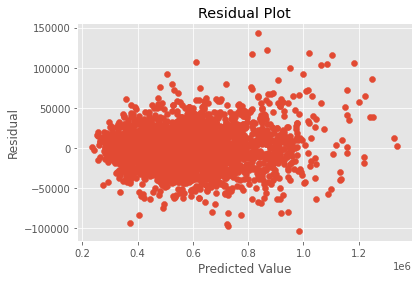

In [82]:
#idk residual plot is vs predicted value or actual value lol
plt.scatter(y_train_pred, train_residuals)
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Residual Plot")

Text(0.5, 1.0, 'Residual Plot')

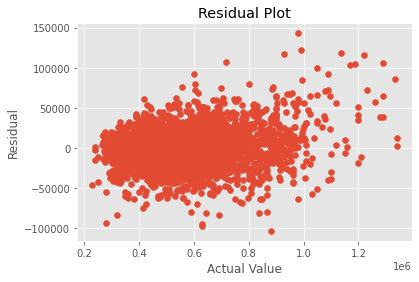

In [83]:
plt.scatter(y_train, train_residuals)
plt.xlabel("Actual Value")
plt.ylabel("Residual")
plt.title("Residual Plot")

Text(0.5, 1.0, 'Actual vs Predicted')

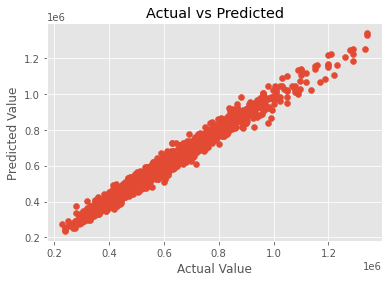

In [84]:
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

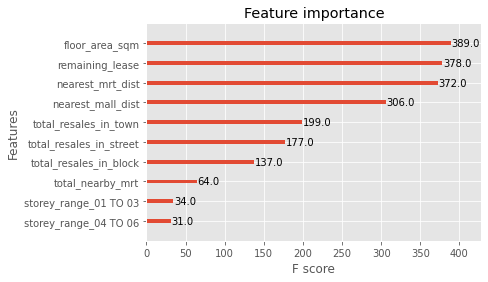

In [85]:
plot_importance(model, max_num_features = 10)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

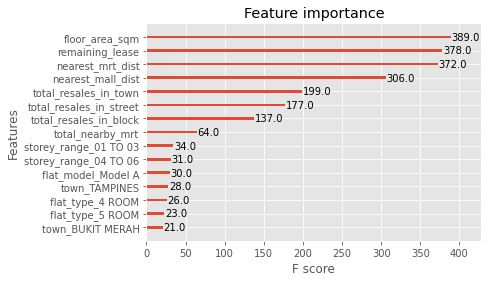

In [86]:
plot_importance(model, max_num_features = 15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


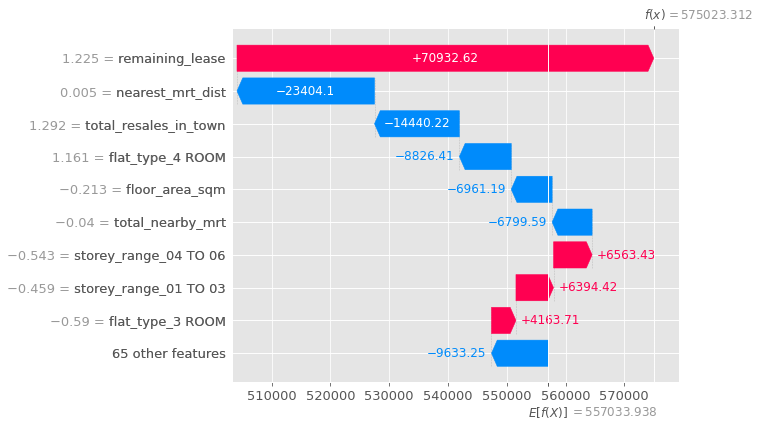

In [87]:
# https://github.com/slundberg/shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# This plot is not useful (?)
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


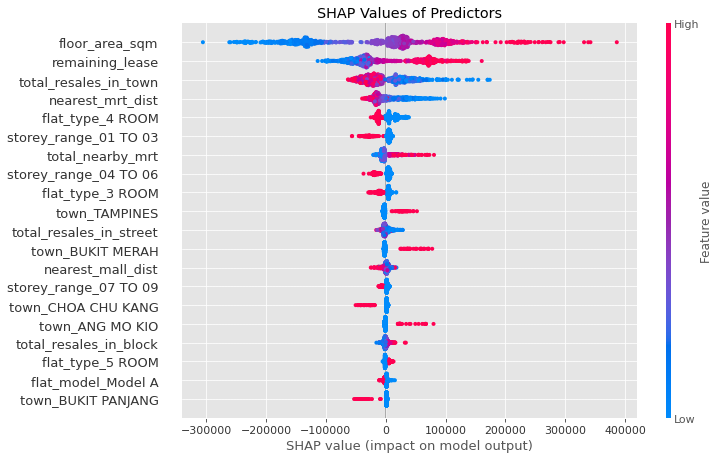

In [88]:
# This plot is v good i think, it shows:
# 1. Higher floor area sqm -> higher price
# 2. Higher remaining lease -> higher price
# 3. Lower total resales in town -> higher price
# 4. Nearer MRT -> higher price
shap.summary_plot(shap_values, X_test, show = False)
plt.title("SHAP Values of Predictors")
plt.gcf().set_size_inches(12,6)

# Price / Sqm

In [ ]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()

train_df2["floor_area_sqm"] = train_df2["floor_area_sqm"].apply(lambda x : x * 23.922319549360488 + 95.09078798185942)
test_df2["floor_area_sqm"] = test_df2["floor_area_sqm"].apply(lambda x : x * 23.922319549360488 + 95.09078798185942)

train_df2["price"]